## Quantum Proposal


For this challenge, the idea of the second proposal will be used and generated in a quantum circuit. And consider the previous inputs of both cases:  12588521, 12583621.

**Now the case 1 must be [1,2,5,8,8,5,2,1];**

**and case 2 must be [1,2,5,8,3,6,2,1]**


For this purpose, different blocks will be considered, such as :

- Generate a vector of positive integers, 
- Inverse of the vector,
- Condition of being equal the number of two vectors.

#### Generate a vector of  positive integers


Encoding to classical to quantum consider the encoding basis, where classical $N$-bit string can be representated as a basis state of a $N$-qubit system. For example, if the classical binary strins  is 101 ,  the quantum state must be $|101\rangle$. 


The case of storing the values in a vector can be represented in a QRAM( some references https://arxiv.org/pdf/0708.1879.pdf, https://github.com/qsharp-community/qram/blob/master/docs/primer.pdf), for this address qubits and information qubits are needed.

From the following vector example [1,5,7,8], for the example is important to use n qubits for the length of the vector and m qubits for the length of the maximum bits representation. The lenght of the vector is 2 and is possible this can be representante in only 2 qubits, because $n^2$, where n is the number of qubits that is $2^2= 4$, therefore n = 2 qubits, for the address, so the state $|00\rangle$ represents the index 1; the state $|01\rangle$ represents the index 1; the state $|10\rangle$ represents the index 2; and the state $11\rangle$ represents the index 3. And m = 4, because the number bigger is 8 in the vector and in the binary representation is $|1000\rangle$.


In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit import Aer, execute

Simple QRAM implementation. Using $\text{MCX}$ and $X$ gates appropriately we can map every address state to its corresponding value in the memory qubits. Notice that we need $\lceil \log_2 N\rceil$ qubits to store $N$ values and $\lfloor \log_2 \text{max_val}\rfloor + 1$ memory qubits where $\text{max_val}$ is the maximum value we want to store (for more details please refer to the references above).

In [2]:
"""
Method to generate the vector in a quantum circuit, 
the quantum circuit depends of a qubit addres value, can select a binary string representation
in the encoding data.

input_vector: Integer value or a list of positive integer values, example 12588521 or [1,2,5,8,8,5,2,1]

return: a quantum circuit that has a set of qubit address and a set of qubit values. 
"""

def qc_vector(input_vector, rev = False, qc = None):
    if isinstance(input_vector, int):
        input_vector = [int(digit) for digit in str(input_vector)]
    
    n = int(np.ceil(np.log2(len(input_vector))))
    m = int(np.floor(np.log2(max(input_vector)))) + 1
    
    addr = QuantumRegister(n, 'addr' + ('_rev' if rev else ''))
    mem = QuantumRegister(m, 'mem' + ('_rev' if rev else ''))
    if qc is None: 
        qc = QuantumCircuit(addr, mem)
    else:
        qc.add_register(addr)
        qc.add_register(mem)
    
    for (i, x) in enumerate(input_vector):
        add_x = []
        for (j, bit) in enumerate(bin(i)[2:].zfill(n)):
            if bit == '0': add_x.append(addr[j])
        if add_x: qc.x(add_x)
        target = []
        for (j, bit) in enumerate(bin(x)[2:].zfill(m)):
            if bit == '1': target.append(mem[j])
        for register in target: 
            qc.mcx(addr, register)
        if add_x: qc.x(add_x)
        qc.barrier(mem, addr)
        
    return [qc, addr, mem]

#### Inverse of the vector

generates a way to represent from the same vector but starting in reversed order, using the previous example [8,7,5,1]. Tip you can use the `qc_vector()` method with previous modification.



In [3]:
"""
Method to generate the vector in a quantum circuit, 
the quantum circuit depends of a qubit addres value, can select a binary string representation
in the encoding data.

input_vector: Integer value or a list of positive integer values, example 12588521 or [1,2,5,8,8,5,2,1]

return: a quantum circuit that has a set of qubit address and a set of qubit values in a reverser order. 
"""

def qc_vector_reverse(input_vector, qc = None):
    if isinstance(input_vector, int):
        input_vector = [int(digit) for digit in str(input_vector)]
    input_vector = input_vector[::-1]
    return qc_vector(input_vector, rev = True, qc = qc)

Here's an example of how the integer $158$ and its reverse ($851$) is stored in our circuit:

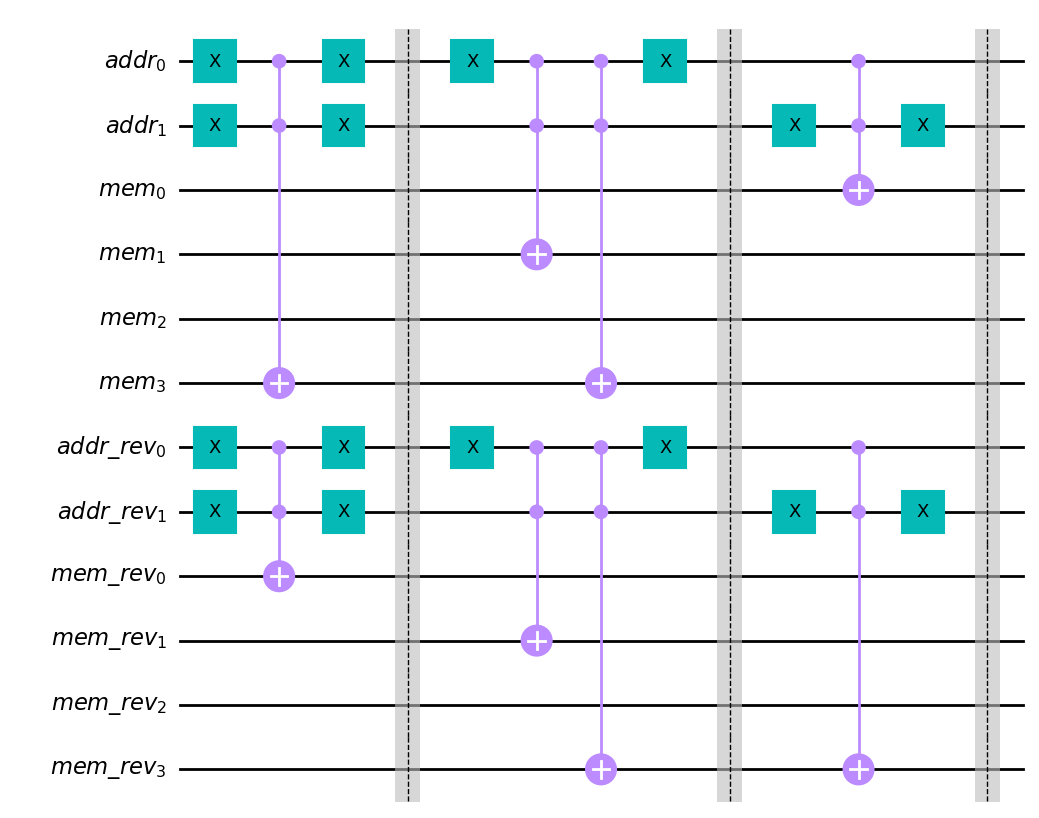

In [4]:
ram_example, _, _ = qc_vector(158)
ram_example, _, _ = qc_vector_reverse(158, qc = ram_example) # we use qc = ram_example to denote that both the original 
                                                       # integer and its inverse will be stored on the same circuit 
ram_example.draw(output='mpl')

#### Condition of being equal the number of two vectors

Design an oracle when two values in a quantum circuit when are different or equals, depend of your choice, activate a flag qubit with a specific state $|0\rangle$ or $|1\rangle$.


Example consider the states $|101\rangle $  and $|110\rangle $, and choice if activate if are equals or different.

The quantum oracle is implemented as follows:
  - There are `3 x qubit_number + 1` wires. The first `2 x qubit_number` wires hold the two states we need to compare
  - Each of the next `qubit_number` wires serves as a flag for the $i$-th qubit pair (it is set to $0/1$ depending on whether the $i$-th qubits of the two states match using two $\text{CNOT}$ gates and an $X$ gate)
  - Using an $\text{MCX}$ gate on the intermediate flag qubits we can set the value of the flag qubit to $1$ if the states are the same of $0$ otherwise

In [5]:
"""
Method to generate an oracle for a  quantum circuit, 
using m+1 qubits, and return a 0 or 1 that neabs different or equals. 

qubit_num: Integer value that representate the values qubits for the qram + 1 , that is the flag qubit. 

return: a quantum circuit that has a set of qubit values + 1 with the flag qubit. 
"""

def quantum_oracle(qubit_number):
    q1 = QuantumRegister(qubit_number, 'q1')
    q2 = QuantumRegister(qubit_number, 'q2')
    aux = QuantumRegister(qubit_number, 'aux')
    flag = QuantumRegister(1, 'f')
    oracle = QuantumCircuit(q1, q2, aux, flag)
    for i in range(qubit_number):
        oracle.cx(q1[i], aux[i])
        oracle.cx(q2[i], aux[i])
        oracle.barrier()
    oracle.x(aux)
    oracle.mcx(aux, flag)
    return oracle 

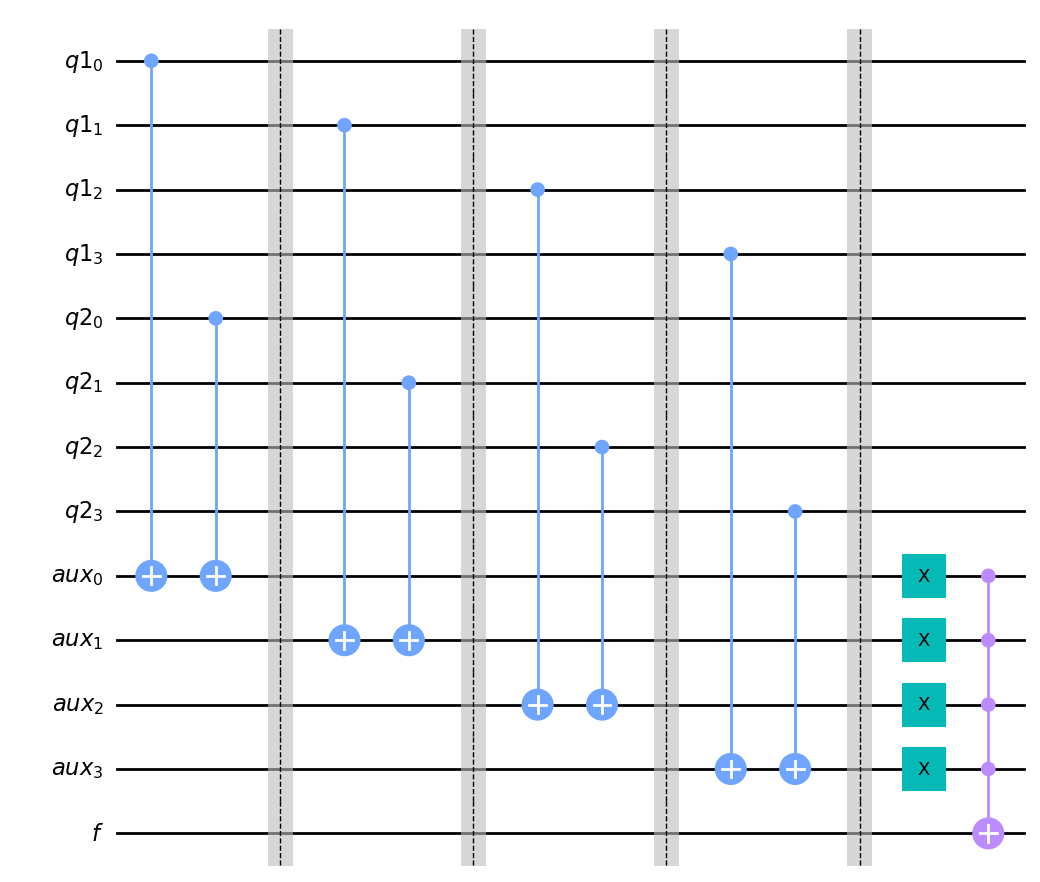

In [6]:
oracle_example = quantum_oracle(4) # An example of the equality check oracle on 4 qubits
oracle_example.draw(output='mpl')

In [7]:
"""
This helper method creates the circuit to identify if the given integer is a palindrome
"""

def combined_circuit(input_value):
    [qc, addr, mem] = qc_vector(input_value)
    [qc, addr_rev, mem_rev] = qc_vector_reverse(input_value, qc = qc)
    oracle = quantum_oracle(len(mem))
    anc = QuantumRegister(len(mem), 'anc')
    flag = QuantumRegister(1, 'f')
    qc.add_register(anc, flag)
    equality = oracle.to_instruction(label='Equal')
    qc.append(equality, list(mem) + list(mem_rev) + list(anc) + list(flag))
    cbit = ClassicalRegister(1, 'ans')
    qc.add_register(cbit)
    qc.measure(flag, cbit)
    init = QuantumCircuit(addr, mem, addr_rev, mem_rev, anc, flag, cbit)
    init.h(addr)
    for (i, qubit) in enumerate(addr):
        init.cx(qubit, addr_rev[i])
    init.barrier(addr, mem, addr_rev, mem_rev)
    return init.compose(qc)


The above circuit uses our equality check oracle with the two memory addresses as its inputs and then measures the flag qubit. If we initialize the $2n$ address qubits in the state
$$\frac{1}{\sqrt{2^n}} \sum_{\mathrm{w}\in \{0,1\}^n}|ww\rangle$$
then its easy to notice that the stored integer is a palindrome if and only if we measure $1$ with probability $1$

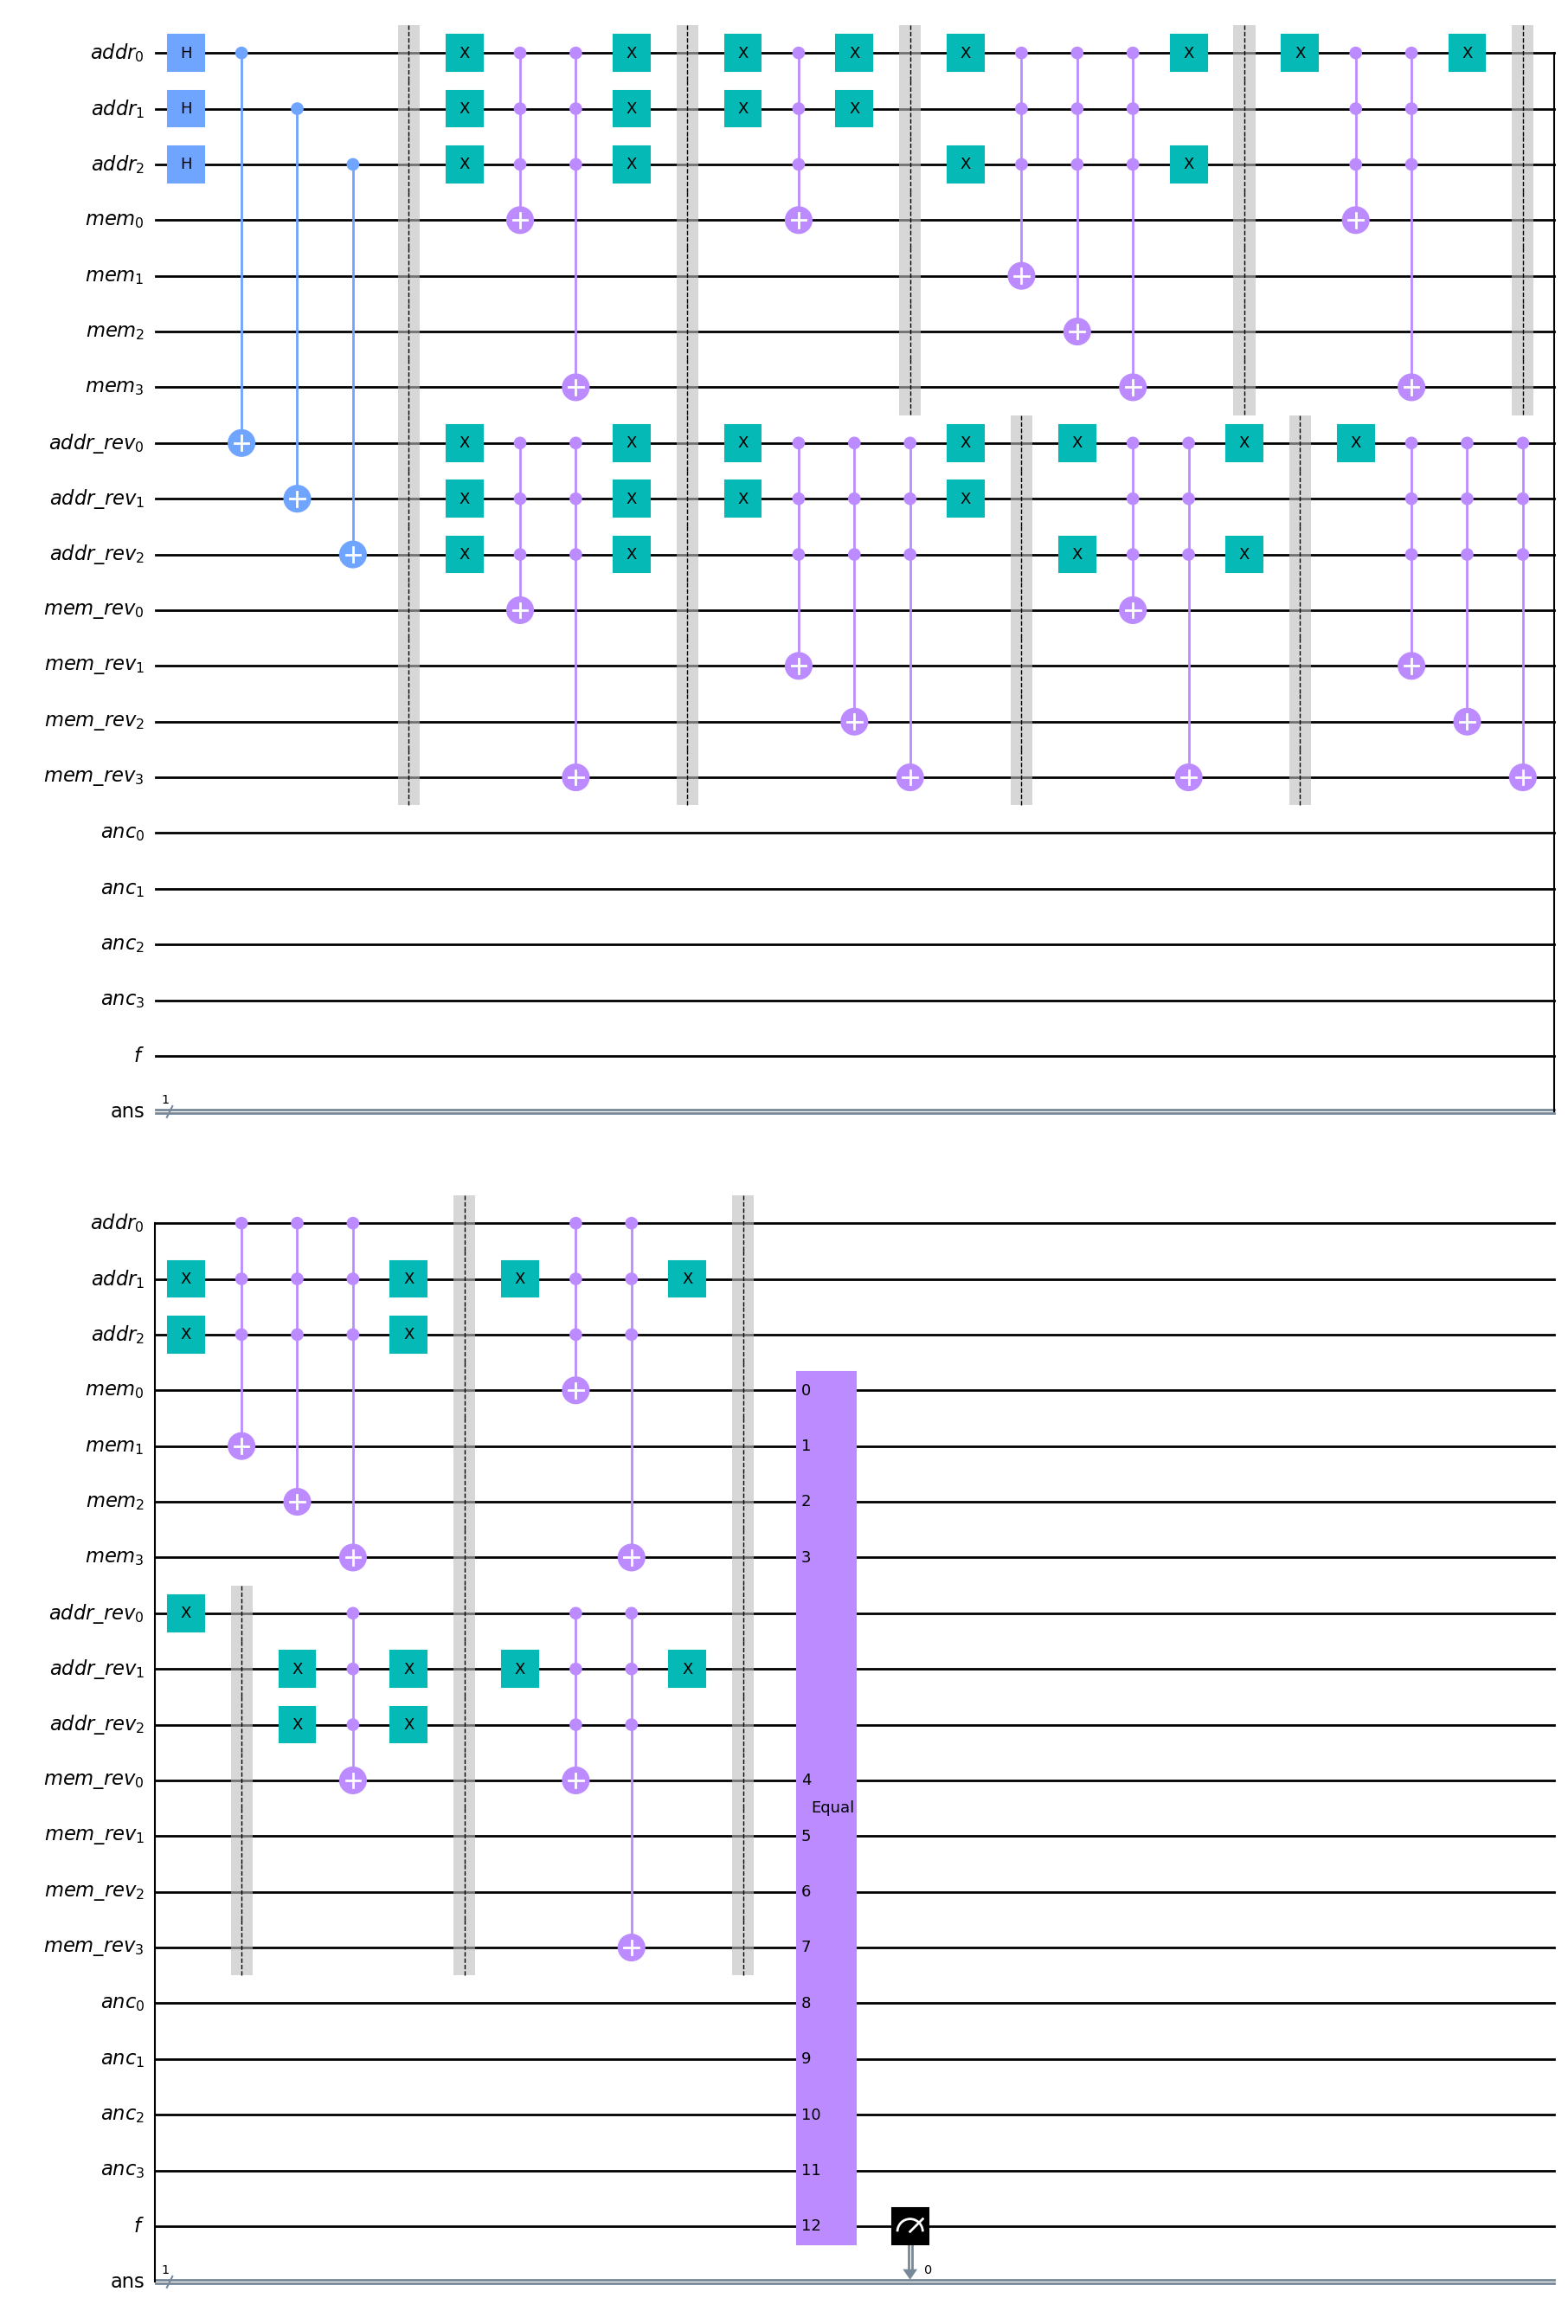

In [14]:
example_circ = combined_circuit(987979) 
example_circ.draw(output='mpl')

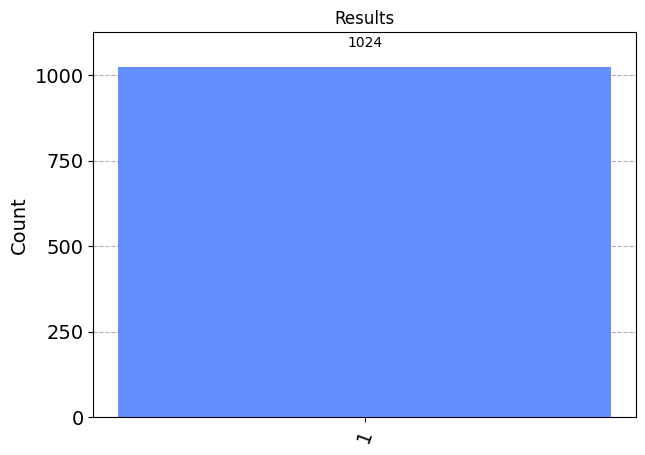

In [9]:
from qiskit.tools.visualization import plot_histogram

simulator = Aer.get_backend('aer_simulator') # simulate circuit and plot results
result = execute(example_circ, simulator).result()

plot_histogram(result.get_counts(), title="Results")

#### Palindrome integer in a quantum circuit 


Using as base the previous functions and/or some auxiliary ones that you consider to be of support and that it returns 0 or1 to represent that it is not or it is a palindrome.

In [10]:
"""
Method to check if a positive integer value  is a palindrome or not.

input value: Integer value.

return: a boolean value that indicates is a palindrome or not the input_vector
"""

def quantum_isPalindrome(input_value):
    circ = combined_circuit(input_value)
    
    simulator = Aer.get_backend('aer_simulator')
    result = execute(circ, simulator).result()

    return result.get_counts().get('0') == None #return 0 or 1

### Check your quantum algorithm


Consider the values of case 1 and case 2 for your proposal:

- 12588521

- 12583621

In [11]:
quantum_isPalindrome(12588521)

True

In [12]:
quantum_isPalindrome(12583621)

False

If you are here is because you do it, congrats 🥳 

## References


[1] Deutsch, David, and Richard Jozsa. "Rapid solution of problems by quantum computation." Proceedings of the Royal Society of London. Series A: Mathematical and Physical Sciences 439.1907 (1992): 553-558., https://www.isical.ac.in/~rcbose/internship/lectures2016/rt08deutschjozsa.pdf

[2] Bernstein, Ethan, and Umesh Vazirani. "Quantum complexity theory." SIAM Journal on computing 26.5 (1997): 1411-1473.https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.655.1186&rep=rep1&type=pdf

[3] Grover, Lov K. , "A fast quantum mechanical algorithm for database search", Proceedings of the 28th Annual ACM Symposium on the Theory of Computing (1996), arXiv:quant-ph/9605043
